In [1]:
import pickle
import numpy as np
# from ExtractBootlegFeatures import *
from ExtractTest import *
import itertools
import numba as nb
from numba import njit
from collections import defaultdict

In [2]:
import dill
from glob import iglob

**Load in databases and counts**

In [3]:
db_dir = "/data1/kji/databases_v3/100mill"

In [4]:
d = {}

In [5]:
for filename in iglob(f"{db_dir}/*.pkl", recursive=True):
    combination = filename.split('/')[-1][:-4]
    with open(filename, "rb") as f:
        d[combination] = pickle.load(f)
    print(f"finished {combination}")

finished 015
finished 014
finished 035
finished 02
finished 03
finished 05
finished 013
finished 04
finished 023
finished 025
finished 045
finished 034
finished 01
finished 012
finished 0
finished 024


In [6]:
with open("/data1/kji/databases/probabilities.pkl", "rb") as f:
    utilities = pickle.load(f)

In [7]:
with open("num_to_piece.pkl", 'rb') as f:
    num_to_piece = pickle.load(f)

In [87]:
from collections import Counter

In [92]:
Counter(num_to_piece).most_common(10)

[(1798, 'p99'),
 (32132, 'p99'),
 (27570, 'p98'),
 (32131, 'p98'),
 (742, 'p97'),
 (32130, 'p97'),
 (28101, 'p96'),
 (32129, 'p96'),
 (331, 'p95'),
 (32128, 'p95')]

In [8]:
combinations = []
for n_gram in range(1, 4):
    combinations += [[0] + list(tup) for tup in itertools.combinations(range(1, 6), n_gram-1)]

In [9]:
combinations = ["".join(str(num) for num in combination) for combination in combinations]

In [10]:
powers = 1 << np.arange(62)[::-1]

In [11]:
def compute_fingerprint(cols):
    fp = []
    equals_Zero = True
    for column in cols:
        hashint = int(column.dot(powers))
        fp.append(hashint)
        if hashint != 0:
            equals_Zero = False
    if equals_Zero == True:
        return None
    return tuple(fp)

In [12]:
def utility(combination, matches):
    return utilities[combination] / matches

In [13]:
def get_ratios(bscore_query, rindex_dict):
    """Inputs: an L x 62 bootleg score query and our dictionary, where
               rindex_dict[fp] = (count, {dictionary of pieces and offsets})
        Output: a 16 X L table where each element is a tuple of (utility:cost ratio, combination, n_gram)"""
    l = len(bscore_query)
    # ratios[i][j] is a pair of (ratio, combination, fingerprint)
    ratios = np.array([[(0, None, None) for _ in range(l)] for _ in range(16)])
    for j in range(l):
        # calculate utility to cost ratio for all 16 n-grams
        for idx, combination in enumerate(combinations):
            cols = []
            # we need at least enough fingerprints for all the indices in our combination
            try:
                for i in combination:
                    cols.append(bscore_query[j+int(i)])
            except IndexError:
                continue
            fp = compute_fingerprint(cols)
            if not fp or combination not in rindex_dict or fp not in rindex_dict[combination]:
                continue
            matches = rindex_dict[combination][fp][0]
#             # TODO: modified
#             if matches > 15000:
#                 continue
            ratios[idx][j] = (utility(combination, matches), combination, fp)
    return ratios

In [180]:
def update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups):
    if num_lookups == 0:
        return
    for piece in pieces_and_offsets:
#         offset = [(j - i, num_lookups) for j in pieces_and_offsets[piece]]
        if num_lookups <= len(pieces_and_offsets[piece]):
            offset = [j - i for j in pieces_and_offsets[piece][:num_lookups]]
        else:
            offset = [j - i for j in pieces_and_offsets[piece]]
        offset_dict[num_to_piece[piece]].extend(offset)
        num_lookups -= len(pieces_and_offsets[piece])
        if num_lookups <= 0:
            break

In [181]:
def get_fingerprints(bscore_query, rindex_dict, ratios, runtime_budget):
    l = len(bscore_query)
    aisle_budget = runtime_budget // l
    cur_budget = aisle_budget
    offset_dict = defaultdict(list)
    matches_processed = 0
    for i in range(l):
        fingerprints = []
        col = ratios[:, i]
        lookups = sorted(col, key = lambda x: x[0], reverse = True)
        for _, combination, n_gram in lookups:
            if not n_gram or cur_budget < 0:
                break
            matches, pieces_and_offsets = rindex_dict[combination][n_gram]
            if cur_budget - matches < 0:
                num_lookups = cur_budget
            else:
                num_lookups = matches
            update_offset_dict(offset_dict, pieces_and_offsets, i, num_lookups)
            cur_budget -= num_lookups
            matches_processed += num_lookups
        cur_budget += aisle_budget
    return offset_dict, matches_processed

In [182]:
def rankHistograms(offset_dict, bin_size=10):
    bin_size = 3
    pieceScores = []
    for key in offset_dict:
        h = offset_dict[key]
        maxh = max(h)
        minh = min(h)
        hist = np.zeros(int((maxh-minh)/bin_size)+2)
        for i in h:
            hist[int((i-minh)/bin_size)] += 1
        score = np.max(hist)
        pieceScores.append((key, score))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores

In [191]:
def processSingleQuery(imagefile, rindex, runtime_budget, outfile = None):
    profileStart = time.time()
    
    # Get Bootleg Score
    bscore_query = processQuery(imagefile)
    bscore_query = bscore_query.T
    
    searchStart = time.time()
    # Generate and rank histograms
    
    ratios = get_ratios(bscore_query, rindex)
    offset_dict, matches_processed = get_fingerprints(bscore_query, rindex, ratios, runtime_budget)
    pieceScores = rankHistograms(offset_dict)
    # Profile & save to file
    profileEnd = time.time()
    
    profileDur = profileEnd - profileStart
    print(matches_processed)
    print(profileDur)
    saveToFile(outfile, imagefile, pieceScores, profileDur, matches_processed)
    return pieceScores

In [192]:
processSingleQuery('data/queries/p51_q10.jpg', d, 100000)

Processing data/queries/p51_q10.jpg
97432
1.0683372020721436


[('dStamaty,_CamilleLe_rythme_des_doigts,_Op.36_272353', 18.0),
 ('dBeethoven,_Ludwig_vanPiano_Sonata_No.18,_Op.31_No.3_51117', 16.0),
 ('dMichaelis,_AlfredNeue_Praktische_Schule_f%C3%BCr_das_Harmonium,_Op.14_519337',
  14.0),
 ('dAlkan,_Charles-Valentin12_Etudes_in_All_the_Minor_Keys,_Op.39_02891',
  12.0),
 ('dMichaelis,_AlfredNeue_Praktische_Schule_f%C3%BCr_das_Harmonium,_Op.14_278816',
  11.0),
 ('dFlagler,_Isaac_Van_VleckVariations_on_an_American_Air_234315', 11.0),
 ('dGottschalk,_Louis_MoreauDernier_Amour,_Op.63_378057', 10.0),
 ('dKnuth,_J%C3%BCrgenPi%C3%A8ces_de_clavecin_avec_une_m%C3%A9thode_94815',
  10.0),
 ('dBellak,_JamesA_New_Method_for_the_Pianoforte_303286', 10.0),
 ('dMoser,_Hans_JoachimTabulatura_Nova,_SSWV_102-158_491667', 9.0),
 ('dJanke,_GustavStandard_Graded_Course_of_Studies_for_the_Pianoforte_345818',
  9.0),
 ('dGouin,_PierreTabulatura_Nova,_SSWV_102-158_491916', 8.0),
 ('dMoser,_Hans_JoachimTabulatura_Nova,_SSWV_102-158_491916', 8.0),
 ('dWollenhaupt,_Hermann

In [193]:
def saveToFile(outfile, imagefile, pieceScores, profileDur, matches_processed):
    if outfile:
        with open(outfile, 'wb') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            pickle.dump((query,pieceScores, profileDur, matches_processed),f)

In [194]:
def processQuery_wrapper(queryfile, rindex, outdir, runtime_budget):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    # might change later to print to outfile
    return processSingleQuery(queryfile, rindex, runtime_budget, hyp_outfile)

In [195]:
runtime_budget = 100000

In [196]:
query_list = 'cfg_files/query.train.list' # list of query images
outdir = 'experiments/v0.3.1/hyp' # where to save hypothesis output files

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load reverse index. Recommend keeping load=False and loading it earlier.
load = False
if load:
    print("LOADING RINDEX")
    rindex1 = []
    with open(pickle_file, 'rb') as f:
        rindex1 = pickle.load(f)
    rindex_filter = rindex1
    
print("STARTING PROCESSING")
# number of cores to use
multiprocess = False
if multiprocess:
    n_cores = 30 #multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=n_cores)

inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), d, outdir, runtime_budget))
        
if multiprocess:
    # process queries in parallel
    outputs = list(pool.starmap(processQuery_wrapper, inputs))
else:
    for i in inputs:
        processQuery_wrapper(i[0], i[1], i[2], i[3])

STARTING PROCESSING
Processing data/queries/p2_q1.jpg
98826
1.2425172328948975
Processing data/queries/p2_q2.jpg
99190
1.1250886917114258
Processing data/queries/p2_q3.jpg
99873
1.0811498165130615
Processing data/queries/p2_q4.jpg
99000
0.9695844650268555
Processing data/queries/p2_q5.jpg
98420
0.9785184860229492
Processing data/queries/p2_q6.jpg
99960
0.903548002243042
Processing data/queries/p2_q7.jpg
99960
1.0168726444244385
Processing data/queries/p2_q8.jpg
99962
0.9574387073516846
Processing data/queries/p2_q9.jpg
99905
0.9270288944244385
Processing data/queries/p2_q10.jpg
99999
0.930511474609375
Processing data/queries/p3_q1.jpg
99946
1.3374590873718262
Processing data/queries/p3_q2.jpg
99960
1.433058738708496
Processing data/queries/p3_q3.jpg
99960
1.1162457466125488
Processing data/queries/p3_q4.jpg
99992
1.0929572582244873
Processing data/queries/p3_q5.jpg
100000
0.9447271823883057
Processing data/queries/p3_q6.jpg
99958
1.0481092929840088
Processing data/queries/p3_q7.jpg
992

99975
0.9762275218963623
Processing data/queries/p18_q10.jpg
99000
1.1133379936218262
Processing data/queries/p19_q1.jpg
99958
0.889014482498169
Processing data/queries/p19_q2.jpg
99960
0.8964121341705322
Processing data/queries/p19_q3.jpg
99946
0.8785078525543213
Processing data/queries/p19_q4.jpg
99968
0.8723809719085693
Processing data/queries/p19_q5.jpg
99938
0.9449124336242676
Processing data/queries/p19_q6.jpg
99990
0.8541092872619629
Processing data/queries/p19_q7.jpg
99960
0.935732364654541
Processing data/queries/p19_q8.jpg
99940
0.9634013175964355
Processing data/queries/p19_q9.jpg
99910
1.0703098773956299
Processing data/queries/p19_q10.jpg
98175
0.8485872745513916
Processing data/queries/p20_q1.jpg
99978
0.823204517364502
Processing data/queries/p20_q2.jpg
99960
0.8992176055908203
Processing data/queries/p20_q3.jpg
99900
0.8787407875061035
Processing data/queries/p20_q4.jpg
99186
0.8925638198852539
Processing data/queries/p20_q5.jpg
99968
0.7817893028259277
Processing data/

99940
0.8786661624908447
Processing data/queries/p36_q7.jpg
99892
0.9145717620849609
Processing data/queries/p36_q8.jpg
99946
1.0744571685791016
Processing data/queries/p36_q9.jpg
99992
0.930304765701294
Processing data/queries/p36_q10.jpg
99130
0.9936230182647705
Processing data/queries/p37_q1.jpg
99996
0.9405381679534912
Processing data/queries/p37_q2.jpg
99900
0.9692461490631104
Processing data/queries/p37_q3.jpg
99900
1.0231034755706787
Processing data/queries/p37_q4.jpg
99892
1.0357372760772705
Processing data/queries/p37_q5.jpg
99999
1.0171253681182861
Processing data/queries/p37_q6.jpg
99990
1.0730443000793457
Processing data/queries/p37_q7.jpg
99964
1.0657052993774414
Processing data/queries/p37_q8.jpg
99946
1.019361972808838
Processing data/queries/p37_q9.jpg
99788
1.1006712913513184
Processing data/queries/p37_q10.jpg
99251
0.9603242874145508
Processing data/queries/p38_q1.jpg
99960
0.9028825759887695
Processing data/queries/p38_q2.jpg
99900
0.9562942981719971
Processing data

99936
1.0517361164093018
Processing data/queries/p53_q4.jpg
99937
1.0196282863616943
Processing data/queries/p53_q5.jpg
99954
1.0090222358703613
Processing data/queries/p53_q6.jpg
99968
0.9677801132202148
Processing data/queries/p53_q7.jpg
99974
1.043813705444336
Processing data/queries/p53_q8.jpg
99960
1.0452375411987305
Processing data/queries/p53_q9.jpg
98484
1.0350656509399414
Processing data/queries/p53_q10.jpg
98073
1.009582281112671
Processing data/queries/p54_q1.jpg
99960
0.9765682220458984
Processing data/queries/p54_q2.jpg
99935
0.9039697647094727
Processing data/queries/p54_q3.jpg
97199
0.8948078155517578
Processing data/queries/p54_q4.jpg
99788
0.8482797145843506
Processing data/queries/p54_q5.jpg
99996
0.9234886169433594
Processing data/queries/p54_q6.jpg
99937
0.9523837566375732
Processing data/queries/p54_q7.jpg
99963
0.90718674659729
Processing data/queries/p54_q8.jpg
99964
0.9131741523742676
Processing data/queries/p54_q9.jpg
99940
0.8913483619689941
Processing data/qu

99883
1.0211944580078125
Processing data/queries/p70_q1.jpg
99892
1.0573511123657227
Processing data/queries/p70_q2.jpg
99968
0.9530489444732666
Processing data/queries/p70_q3.jpg
99990
1.0569648742675781
Processing data/queries/p70_q4.jpg
99978
0.9781630039215088
Processing data/queries/p70_q5.jpg
99935
0.9200224876403809
Processing data/queries/p70_q6.jpg
99900
1.1123511791229248
Processing data/queries/p70_q7.jpg
99968
0.8960545063018799
Processing data/queries/p70_q8.jpg
99960
0.9151549339294434
Processing data/queries/p70_q9.jpg
99900
1.1126840114593506
Processing data/queries/p70_q10.jpg
99960
0.9597358703613281
Processing data/queries/p72_q1.jpg
99892
0.8639729022979736
Processing data/queries/p72_q2.jpg
99960
0.8787581920623779
Processing data/queries/p72_q3.jpg
99904
0.8629710674285889
Processing data/queries/p72_q4.jpg
99904
0.8477721214294434
Processing data/queries/p72_q5.jpg
99937
0.8306245803833008
Processing data/queries/p72_q6.jpg
99978
0.8120157718658447
Processing dat

98820
0.9235918521881104
Processing data/queries/p87_q8.jpg
99946
0.9760336875915527
Processing data/queries/p87_q9.jpg
99960
1.3928313255310059
Processing data/queries/p87_q10.jpg
99946
1.0814003944396973
Processing data/queries/p88_q1.jpg
99960
1.3198802471160889
Processing data/queries/p88_q2.jpg
99960
1.0632784366607666
Processing data/queries/p88_q3.jpg
99958
1.0772173404693604
Processing data/queries/p88_q4.jpg
99990
1.113286018371582
Processing data/queries/p36_q10.jpg
99130
0.989973783493042
Processing data/queries/p37_q1.jpg
99996
0.9968338012695312
Processing data/queries/p37_q2.jpg
99900
1.3162171840667725
Processing data/queries/p88_q8.jpg
99918
1.132413625717163
Processing data/queries/p88_q9.jpg
99975
1.1950132846832275
Processing data/queries/p88_q10.jpg
99990
1.0552363395690918
Processing data/queries/p89_q1.jpg
99935
0.8746051788330078
Processing data/queries/p89_q2.jpg
99947
0.9641287326812744
Processing data/queries/p89_q3.jpg
99968
0.9118838310241699
Processing data

99918
1.0769011974334717
Processing data/queries/p104_q5.jpg
99941
0.9522686004638672
Processing data/queries/p104_q6.jpg
99944
0.957287073135376
Processing data/queries/p104_q7.jpg
99918
0.6857109069824219
Processing data/queries/p104_q8.jpg
99981
1.260568618774414
Processing data/queries/p104_q9.jpg
100000
1.5563876628875732
Processing data/queries/p104_q10.jpg
99992
1.300525188446045
Processing data/queries/p106_q1.jpg
99879
1.0393524169921875
Processing data/queries/p106_q2.jpg
99828
1.026554822921753
Processing data/queries/p106_q3.jpg
99330
0.9682681560516357
Processing data/queries/p106_q4.jpg
99864
1.3392038345336914
Processing data/queries/p106_q5.jpg
99912
1.1653945446014404
Processing data/queries/p106_q6.jpg
99975
1.0992345809936523
Processing data/queries/p106_q7.jpg
99936
0.9723496437072754
Processing data/queries/p106_q8.jpg
99900
0.9059457778930664
Processing data/queries/p106_q9.jpg
99900
0.9911675453186035
Processing data/queries/p106_q10.jpg
99996
0.614081859588623
P

99968
0.7787919044494629
Processing data/queries/p120_q10.jpg
99992
0.7525684833526611
Processing data/queries/p122_q1.jpg
97935
1.0465607643127441
Processing data/queries/p122_q2.jpg
97820
1.0592365264892578
Processing data/queries/p122_q3.jpg
99267
1.137758731842041
Processing data/queries/p122_q4.jpg
99990
1.0460011959075928
Processing data/queries/p122_q5.jpg
93840
1.1901447772979736
Processing data/queries/p122_q6.jpg
99958
1.2857682704925537
Processing data/queries/p122_q7.jpg
99990
0.9229729175567627
Processing data/queries/p122_q8.jpg
99937
1.1887738704681396
Processing data/queries/p122_q9.jpg
98670
1.6367323398590088
Processing data/queries/p122_q10.jpg
98220
1.3217365741729736
Processing data/queries/p123_q1.jpg
99954
1.4664011001586914
Processing data/queries/p123_q2.jpg
99960
1.0737929344177246
Processing data/queries/p123_q3.jpg
99912
1.0467958450317383
Processing data/queries/p123_q4.jpg
99120
1.267385482788086
Processing data/queries/p123_q5.jpg
99936
1.1411495208740234

99944
1.0313005447387695
Processing data/queries/p138_q5.jpg
99960
0.9913232326507568
Processing data/queries/p138_q6.jpg
99954
0.9937107563018799
Processing data/queries/p138_q7.jpg
99905
1.2043321132659912
Processing data/queries/p138_q8.jpg
99946
1.2530043125152588
Processing data/queries/p138_q9.jpg
99944
1.0660884380340576
Processing data/queries/p138_q10.jpg
99960
0.932065486907959
Processing data/queries/p139_q1.jpg
95612
0.9807875156402588
Processing data/queries/p139_q2.jpg
99984
0.8338973522186279
Processing data/queries/p139_q3.jpg
99990
0.7950661182403564
Processing data/queries/p139_q4.jpg
95200
0.8377971649169922
Processing data/queries/p139_q5.jpg
99968
0.8751373291015625
Processing data/queries/p139_q6.jpg
94342
0.9946866035461426
Processing data/queries/p139_q7.jpg
99968
1.0945920944213867
Processing data/queries/p139_q8.jpg
99960
1.0725469589233398
Processing data/queries/p139_q9.jpg
99988
0.8524248600006104
Processing data/queries/p139_q10.jpg
99994
0.846918582916259

99817
0.9455907344818115
Processing data/queries/p154_q10.jpg
0
0.23232030868530273
Processing data/queries/p156_q1.jpg
99922
0.9000763893127441
Processing data/queries/p156_q2.jpg
99343
0.7822425365447998
Processing data/queries/p156_q3.jpg
99858
0.9934511184692383
Processing data/queries/p156_q4.jpg
99968
1.17759370803833
Processing data/queries/p156_q5.jpg
99822
1.3966448307037354
Processing data/queries/p156_q6.jpg
99864
1.083460807800293
Processing data/queries/p156_q7.jpg
99990
0.9183132648468018
Processing data/queries/p156_q8.jpg
99946
1.008500099182129
Processing data/queries/p156_q9.jpg
99852
0.9484288692474365
Processing data/queries/p156_q10.jpg
99960
0.9073469638824463
Processing data/queries/p157_q1.jpg
98270
1.0419492721557617
Processing data/queries/p157_q2.jpg
99936
0.840045690536499
Processing data/queries/p157_q3.jpg
99938
0.9306187629699707
Processing data/queries/p157_q4.jpg
100000
0.8337116241455078
Processing data/queries/p157_q5.jpg
99960
0.7616820335388184
Proc

99975
0.9438209533691406
Processing data/queries/p172_q5.jpg
99892
1.0054700374603271
Processing data/queries/p172_q6.jpg
99957
1.6217679977416992
Processing data/queries/p172_q7.jpg
99960
1.2705235481262207
Processing data/queries/p172_q8.jpg
99975
1.1170032024383545
Processing data/queries/p172_q9.jpg
99958
1.0375745296478271
Processing data/queries/p172_q10.jpg
99946
0.8723917007446289
Processing data/queries/p173_q1.jpg
99965
0.9001264572143555
Processing data/queries/p173_q2.jpg
99965
0.9678995609283447
Processing data/queries/p173_q3.jpg
99960
0.9955904483795166
Processing data/queries/p173_q4.jpg
99990
0.9557383060455322
Processing data/queries/p173_q5.jpg
99912
0.9761836528778076
Processing data/queries/p173_q6.jpg
99975
0.9827392101287842
Processing data/queries/p173_q7.jpg
99990
0.9326915740966797
Processing data/queries/p173_q8.jpg
99946
0.9703161716461182
Processing data/queries/p173_q9.jpg
100000
1.1077747344970703
Processing data/queries/p173_q10.jpg
99949
1.1090805530548

99957
1.2043986320495605
Processing data/queries/p188_q10.jpg
99947
1.0926573276519775
Processing data/queries/p189_q1.jpg
99900
0.935779333114624
Processing data/queries/p189_q2.jpg
99960
0.9396078586578369
Processing data/queries/p189_q3.jpg
99979
0.9367079734802246
Processing data/queries/p189_q4.jpg
99946
1.0213470458984375
Processing data/queries/p189_q5.jpg
99960
1.0745179653167725
Processing data/queries/p189_q6.jpg
99918
1.0006892681121826
Processing data/queries/p189_q7.jpg
99964
1.099123239517212
Processing data/queries/p189_q8.jpg
99941
1.0151333808898926
Processing data/queries/p189_q9.jpg
99876
1.1355996131896973
Processing data/queries/p189_q10.jpg
99969
1.00758957862854
Processing data/queries/p190_q1.jpg
99960
1.0471866130828857
Processing data/queries/p190_q2.jpg
99904
1.0620551109313965
Processing data/queries/p190_q3.jpg
99938
1.2334158420562744
Processing data/queries/p190_q4.jpg
99937
0.890052318572998
Processing data/queries/p190_q5.jpg
99904
0.9987781047821045
Pr

In [13]:
len(d)

16

In [7]:
n_gram_count = defaultdict(int)

In [8]:
for i in d:
    n_gram_count[i] = len(d[i])

In [9]:
n_gram_count

defaultdict(int, {'three_grams': 46654034, 'two_grams': 11721009, '0': 616977})

In [10]:
total_matches = 0

In [11]:
for combination in d:
    for fp in d[combination]:
        total_matches += d[combination][fp][0]

In [12]:
total_matches

5734709365

## Test code

In [13]:
def get_counts(d):
    """given a database, returns a dictionary mapping each piece to the number of unique fingerprints it has in IMSLP"""
    counts = defaultdict(int)
    for combination in d:
        db = d[combination]
        for fp in db:
            for piece in db[fp][1]:
                counts[piece] += 1
    return counts

In [14]:
def get_coverage(counts, total_pieces):
    """
    given a dictionary of counts, return an array where a[i] is the percent of 
    items in IMSLP with at least i+1 unique fingerprints
    """
    num_pieces_per_count = defaultdict(int)
    for num in counts.values():
        num_pieces_per_count[num] += 1
    n = max(num_pieces_per_count)
    cumulative_counts = []
    cur_count = 0
    for i in reversed(range(1, n+1)):
        cur_count += num_pieces_per_count[i]
        cumulative_counts.append(cur_count)
    return [count / total_pieces for count in cumulative_counts[::-1]]

In [15]:
counts = get_counts(d)

In [139]:
with open("data/v3_counts.pkl", "rb") as f:
    counts = pickle.load(f)

In [187]:
for k in l:
    if l[k] < 1000:
        print(k)

p76


In [197]:
l['p118']

3054

<AxesSubplot:ylabel='Count'>

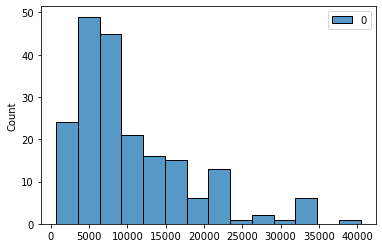

In [174]:
sns.histplot(l.values())

In [176]:
np.mean(list(l.values()))
np.min(list(l.values()))

681

In [164]:
l = {}

In [172]:
del counts['x']

In [173]:
for piece in counts:
    if num_to_piece[piece][0] == 'p':
        l[num_to_piece[piece]] = counts[piece]

In [144]:
counts[1515]

3771

In [17]:
with open("data/merged_23_grams_counts.pkl", "wb") as f:
    pickle.dump(counts, f)

In [18]:
total = 30275

In [19]:
percents = get_coverage(counts, total)

In [20]:
with open("data/percent_merged_23_grams.pkl", "wb") as f:
    pickle.dump(percents, f)